# Tutorial with 1d advection equation

Jiawei Zhuang 7/24/2019 (updated 02/13/2020)

In [1]:
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
# %tensorflow_version 1.x

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

  Cloning https://github.com/JiaweiZhuang/data-driven-pdes (to revision fix-beam) to c:\users\tmn\appdata\local\temp\pip-req-build-seg36ewb


  Running command git clone -q https://github.com/JiaweiZhuang/data-driven-pdes 'C:\Users\TMN\AppData\Local\Temp\pip-req-build-seg36ewb'
  Running command git checkout -b fix-beam --track origin/fix-beam
  Branch 'fix-beam' set up to track remote branch 'fix-beam' from 'origin'.
  Switched to a new branch 'fix-beam'
You should consider upgrading via the 'D:\Files\PycharmProjects\ML_2\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

# from google.colab import files  # colab-specific utilities; comment out when running locally

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__

('1.15.0', '2.2.4-tf')

In [3]:
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Define simulation grids

In [4]:
# we mostly run simulation on coarse grid
# the fine grid is only for obtaining training data and generate the reference "truth"

grid_length = 32
fine_grid_resolution = 256
coarse_grid_resolution = 32

assert fine_grid_resolution % coarse_grid_resolution == 0


In [5]:
# 1d domain, so only 1 point along y dimension

fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )

coarse_grid = grids.Grid(
    size_x=coarse_grid_resolution, size_y=1, 
    step=grid_length/coarse_grid_resolution
    )

x_fine, _ = fine_grid.get_mesh()
x_coarse, _ = coarse_grid.get_mesh()

x_fine.shape, x_coarse.shape

((256, 1), (32, 1))

# Generate initial condition

In [6]:
def make_square(x, height=1.0, center=0.25, width=0.1):
  """
  Args:
    x: Numpy array. Shape should be (nx, 1) or (nx,)
    height: float, peak concentration
    center: float, relative center position in 0~1
    width: float, relative width in 0~0.5

  Returns:
    Numpy array, same shape as `x`
  """
  nx = x.shape[0]
  c = np.zeros_like(x)
  c[int((center-width)*nx):int((center+width)*nx)] = height
  return c

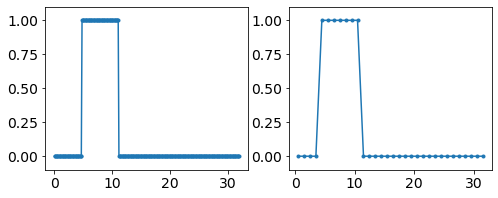

In [7]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].plot(x_fine, make_square(x_fine), marker='.')
axes[1].plot(x_coarse, make_square(x_coarse), marker='.')

for ax in axes:
  ax.set_ylim(-0.1, 1.1)

In [8]:
def make_multi_square(x, height_list, width_list):
  c_list = []
  for height in height_list:
    for width in width_list:
      c_temp = make_square(x, height=height, width=width)
      c_list.append(c_temp)

  return np.array(c_list)

height_list = np.arange(0.1, 1.1, 0.1)
width_list = np.arange(1/16, 1/4, 1/16)  # width is chosen so that coarse-graining of square wave is symmetric

c_init = make_multi_square(
  x_coarse,
  height_list = height_list,
  width_list = width_list
)

c_init.shape  # (sample, x, y)

(30, 32, 1)

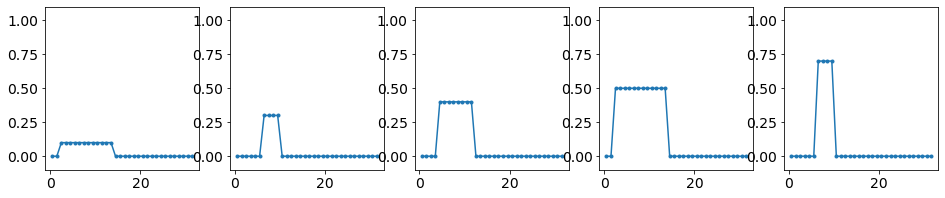

In [9]:
fig, axes = plt.subplots(1, 5, figsize=[16, 3])

for i, ax in enumerate(axes):
  ax.plot(x_coarse, c_init[4*i+2, :, 0], marker='.')
  ax.set_ylim(-0.1, 1.1)

# Wrap with velocity fields

In [10]:
# for simplicity, use uniform constant velocity field for all samples

initial_state = {
    'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init.shape, np.float32)
}

for k, v in initial_state.items():
  print(k, v.shape)   # (sample, x, y)

concentration (30, 32, 1)
x_velocity (30, 32, 1)
y_velocity (30, 32, 1)


# Run baseline advection solver

In [11]:
# first-order finite difference model, very diffusive
model_1st = models.FiniteDifferenceModel(
    advection_equations.UpwindAdvection(cfl_safety_factor=0.5), 
    coarse_grid
    )

# second-order scheme with monotonic flux limiter
model_2nd = models.FiniteDifferenceModel(
    advection_equations.VanLeerAdvection(cfl_safety_factor=0.5), 
    coarse_grid
    )

In [12]:
time_steps = np.arange(0, 256+1)

In [13]:
%time integrated_1st = integrate.integrate_steps(model_1st, initial_state, time_steps)
%time integrated_2nd = integrate.integrate_steps(model_2nd, initial_state, time_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Wall time: 328 ms
Wall time: 1.37 s


In [14]:
for k, v in integrated_1st.items():
  print(k, v.shape)   # (time, sample, x, y)

concentration (257, 30, 32, 1)
x_velocity (257, 30, 32, 1)
y_velocity (257, 30, 32, 1)


In [15]:
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr

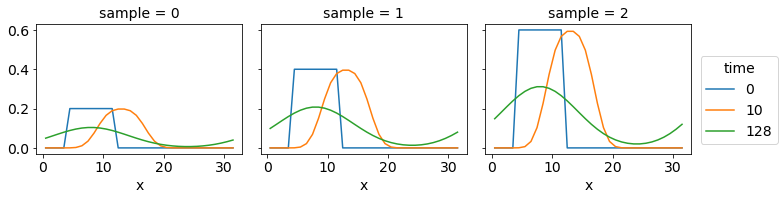

In [16]:
dr_1st = wrap_as_xarray(integrated_1st)
dr_1st.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')

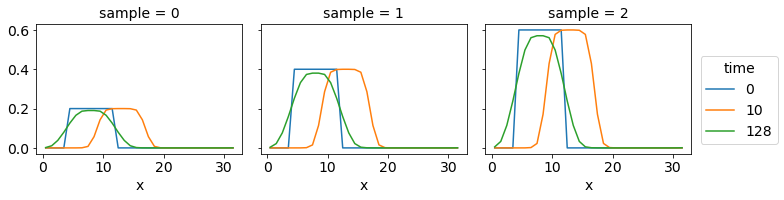

In [17]:
dr_2nd = wrap_as_xarray(integrated_2nd)
dr_2nd.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')

# Run untrained neural net model

In [18]:
model_nn = models.PseudoLinearModel(
    advection_equations.FiniteVolumeAdvection(0.5), 
    coarse_grid,
    num_time_steps=4,  # multi-step loss function
    stencil_size=3, kernel_size=(3, 1), num_layers=4, filters=32,
    constrained_accuracy_order=1, 
    learned_keys = {'concentration_edge_x', 'concentration_edge_y'},  # finite volume view, use edge concentration
    activation='relu',
)

model_nn.learned_keys, model_nn.fixed_keys

({'concentration_edge_x', 'concentration_edge_y'},
 {'concentration', 'x_velocity', 'y_velocity'})

In [19]:
tf.random.set_random_seed(0)

%time integrated_untrained = integrate.integrate_steps(model_nn, initial_state, time_steps)

Wall time: 2.32 s


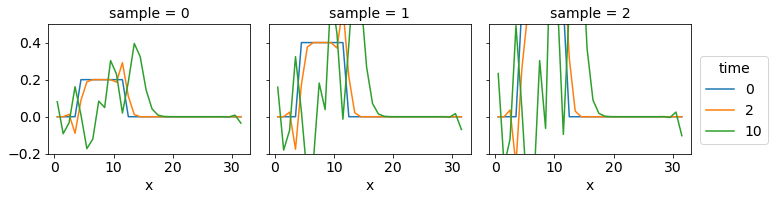

In [20]:
(wrap_as_xarray(integrated_untrained)
.isel(time=[0, 2, 10], sample=[4, 10, 16])
.plot(col='sample', hue='time', ylim=[-0.2, 0.5])
)
# untrained model is diverging! 

In [21]:
# weights are initialized at the first model call
len(model_nn.get_weights())

8

In [22]:
model_nn.get_weights()[0].shape # first convolutional filter, (x, y, input_channel, filter_channel) 

(3, 1, 3, 32)

In [23]:
model_nn.get_weights()[2].shape # second convolutional filter, (x, y, filter_channel, filter_channel) 

(3, 1, 32, 32)

# Generate training data from high-resolution baseline simulations

In [24]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.5)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

In [25]:
# need to re-evaluate initial condition on high-resolution grid

c_init_fine = make_multi_square(
  x_fine,
  height_list = height_list,
  width_list = width_list
)

initial_state_fine = {
    'concentration': c_init_fine.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_fine.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_fine.shape, np.float32)
}

%time integrated_ref = reference_solution(initial_state_fine, fine_grid, coarse_grid)
train_input, train_output = make_train_data(integrated_ref)

Wall time: 33.6 s

 train_input shape:
concentration (7590, 32, 1)
x_velocity (7590, 32, 1)
y_velocity (7590, 32, 1)

 train_output shape: (7590, 4, 32, 1)


In [26]:
[v.shape for v in initial_state_fine.values()]

[(30, 256, 1), (30, 256, 1), (30, 256, 1)]

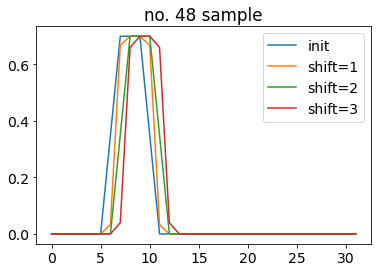

In [27]:
# make sure that single-step input corresponds to multi-step (advected) output

i_sample = 48  # any number between 0 and train_output.shape[0]

plt.plot(train_input['concentration'][i_sample].numpy(), label='init')
for shift in range(train_output.shape[1])[:3]:
  plt.plot(train_output[i_sample, shift].numpy(), label=f'shift={shift+1}')

plt.title(f'no. {i_sample} sample')
plt.legend()

# Train neural net model

Can skip to the next section "load existing weights" if weights have been saved before.

In [28]:
%%time 
# same as training standard Keras model
model_nn.compile(
    optimizer='adam', loss='mae'
    )

tf.random.set_random_seed(42)
np.random.seed(42)

history = model_nn.fit(
    train_input, train_output, epochs=120, batch_size=32, 
    verbose=1, shuffle=True
    )

Instructions for updating:
ksizes is deprecated, use sizes instead
Train on 7590 samples
Epoch 1/120
7590/7590 [==============================] - 6s 854us/sample - loss: 0.0045

<AxesSubplot:>

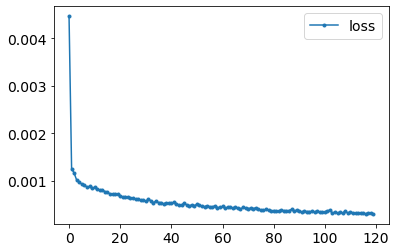

In [29]:
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')

<AxesSubplot:>

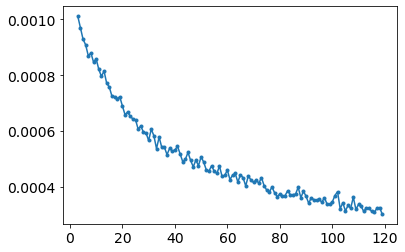

In [30]:
df_history['loss'][3:].plot(marker='.')
# might not converged yet

## Save trained model

In [31]:
model_utils.save_weights(model_nn, 'weights_1d_120epochs.h5')

In [33]:
# files.download('weights_1d_120epochs.h5')

# Or directly load trained model

Need to manually upload weights as Colab local file

In [34]:
model_utils.load_weights(model_nn, 'weights_1d_120epochs.h5')

AttributeError: 'str' object has no attribute 'decode'

# Integrate trained model

In [ ]:
%time integrated_nn = integrate.integrate_steps(model_nn, initial_state, time_steps)

In [ ]:
dr_nn = wrap_as_xarray(integrated_nn)
dr_nn.sizes

In [ ]:
dr_nn.isel(time=[0, 10, 128], sample=[4, 10, 16]).plot(col='sample', hue='time')
# much better than traditional finite difference scheme

## Evaluate accuracy on training set

Here just test on training data. Next section makes new test data.

In [ ]:
dr_ref = wrap_as_xarray(integrated_ref)  # reference "truth"

dr_all_train = xarray.concat([dr_nn, dr_2nd, dr_1st, dr_ref], dim='model')
dr_all_train.coords['model'] = ['nn', '2nd', '1st', 'ref']

In [ ]:
(dr_all_train.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)
# neural net model (blue line) almost overlaps with reference truth (red line); so lines are hard to see clearly

In [ ]:
(
  (dr_all_train.sel(model=['nn', '1st', '2nd']) - dr_all_train.sel(model='ref'))
  .pipe(abs).mean(dim=['x', 'sample'])  # mean absolute error
  .isel(time=slice(0, 129, 2))  # the original error series oscillates between odd & even steps, because CFL=0.5
  .plot(hue='model')
)
plt.title('Error on training set')
plt.grid()

# Prediction on new test data

In [ ]:
np.random.seed(41)
height_list_test = np.random.uniform(0.1, 0.9, size=10) 
# width_list_test = np.random.uniform(1/16, 1/4, size=3)  
# doesn't make sense to randomly sample widths of square waves, as a square has to align with grid

c_init_test = make_multi_square(
  x_coarse,
  height_list = height_list_test,
  width_list = width_list  # just use width in training set
)

c_init_test.shape  # (sample, x, y)

In [ ]:
height_list_test # , width_list_test

In [ ]:
plt.plot(x_coarse, c_init_test[5])

In [ ]:
initial_state_test = {
    'concentration': c_init_test.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_test.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_test.shape, np.float32)
}

for k, v in initial_state_test.items():
  print(k, v.shape)

In [ ]:
%time dr_nn_test = wrap_as_xarray(integrate.integrate_steps(model_nn, initial_state_test, time_steps))

%time dr_1st_test = wrap_as_xarray(integrate.integrate_steps(model_1st, initial_state_test, time_steps))

%time dr_2nd_test = wrap_as_xarray(integrate.integrate_steps(model_2nd, initial_state_test, time_steps))

In [ ]:
dr_sol_test = xarray.concat([dr_nn_test, dr_2nd_test, dr_1st_test], dim='model')
dr_sol_test.coords['model'] = ['Neural net', 'Baseline', 'First order']

(dr_sol_test.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)

plt.ylim(0, 1)

In [ ]:
(dr_sol_test.isel(time=[0, 16, 64, 256], sample=16).rename({'time': 'Time step'})
.plot(hue='model', col='Time step', alpha=0.6, col_wrap=2, linewidth=2, figsize=[6, 4.5], ylim=[None, 0.8])
)

plt.suptitle('Advection under 1-D constant velocity', y=1.05)
plt.savefig('1d-test-sample.png', dpi=288, bbox_inches='tight')

In [ ]:
# files.download('1d-test-sample.png')

### Reference solution for test set

In [ ]:
# need to re-evaluate initial condition on high-resolution grid

c_init_fine_test = make_multi_square(
  x_fine,
  height_list = height_list_test,
  width_list = width_list
)

initial_state_fine_test = {
    'concentration': c_init_fine_test.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_fine_test.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_fine_test.shape, np.float32)
}

%time integrated_ref_test = reference_solution(initial_state_fine_test, fine_grid, coarse_grid)

dr_ref_test = wrap_as_xarray(integrated_ref_test)  # reference "truth"

In [ ]:
dr_all_test = xarray.concat([dr_nn_test, dr_2nd_test, dr_1st_test, dr_ref_test], dim='model')
dr_all_test.coords['model'] = ['Neural net', 'Baseline', 'First order', 'Reference']

In [ ]:
(dr_all_test.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='model', col='time', row='sample', alpha=0.6, linewidth=2)
)

plt.ylim(0, 1)

In [ ]:
(dr_all_test.isel(time=[0, 16, 64, 256], sample=16).rename({'time': 'Time step'})
.plot(hue='model', col='Time step', alpha=0.6, col_wrap=2, linewidth=2, figsize=[6, 4.5], ylim=[None, 0.8])
)

plt.suptitle('Advection under 1-D constant velocity', y=1.05)
# plt.savefig('1d-test-sample.png', dpi=288, bbox_inches='tight')

## Plot test accuracy

In [ ]:
(
  (dr_all_test.sel(model=['Neural net', 'Baseline', 'First order']) - dr_all_test.sel(model='Reference'))
  .pipe(abs).mean(dim=['x', 'sample'])  # mean absolute error
  .isel(time=slice(0, 257, 2))  # the original error series oscillates between odd & even steps, because CFL=0.5
  .plot(hue='model', figsize=[4.5, 3.5], linewidth=2.0)
)
plt.title('Error for 1-D advection')
plt.xlabel('Time step')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid()
plt.xticks(range(0, 257, 50))
plt.savefig('1d-test-mae.png', dpi=288, bbox_inches='tight')

In [ ]:
# files.download('1d-test-mae.png')

# Out-of-sample prediction

In [ ]:
def make_gaussian(x, height=1.0, center=0.25, width=0.1):
  """
  Args:
    x: Numpy array. Shape should be (nx, 1) or (nx,)
    height: float, peak concentration
    center: float, relative center position in 0~1
    width: float, relative width in 0~0.5

  Returns:
    Numpy array, same shape as `x`
  """
  nx = x.shape[0]
  x_max = x.max()
  center *= x_max
  width *= x_max
  c = height * np.exp(-(x-center)**2 / width**2)
  return c

def make_multi_gaussian(x, height_list, width_list):
  c_list = []
  for height in height_list:
    for width in width_list:
      c_temp = make_gaussian(x, height=height, width=width)
      c_list.append(c_temp)

  return np.array(c_list)

In [ ]:
np.random.seed(41)
height_list_guass = np.random.uniform(0.1, 0.5, size=10) 
width_list_guass = np.random.uniform(1/16, 1/4, size=3)

c_init_guass = make_multi_gaussian(
  x_coarse,
  height_list = height_list_guass,
  width_list = width_list_guass
)

c_init_guass.shape  # (sample, x, y)

In [ ]:
height_list_guass, width_list_guass

In [ ]:
plt.plot(x_coarse, make_gaussian(x_coarse, height=0.5))

In [ ]:
initial_state_gauss = {
    'concentration': c_init_guass.astype(np.float32),  # tensorflow code expects float32
    'x_velocity': np.ones(c_init_guass.shape, np.float32) * 1.0,
    'y_velocity': np.zeros(c_init_guass.shape, np.float32)
}

for k, v in initial_state_gauss.items():
  print(k, v.shape)

In [ ]:
%time dr_nn_gauss = wrap_as_xarray(integrate.integrate_steps(model_nn, initial_state_gauss, time_steps))

In [ ]:
(dr_nn_gauss.isel(time=[0, 16, 64, 128, 256], sample=[4, 10, 16])
.plot(hue='time', col='sample', alpha=0.6, linewidth=2)
)

In [ ]:
(dr_nn_gauss.isel(time=[0, 4, 16, 64], sample=[0, 4, 16])
.plot(col='time', hue='sample', col_wrap=4, alpha=0.6, linewidth=2)
)
plt.suptitle('Out-of-sample prediction', y=1.05)

In [ ]:
(dr_nn_gauss.isel(time=[0, 16, 64, 256], sample=[0, 4, 29]).rename({'time': 'Time step'})
.plot(col='Time step', hue='sample', alpha=0.6, linewidth=2, col_wrap=2, figsize=[6, 4.5])
)
plt.suptitle('Neural net out-of-sample prediction', y=1.05)
plt.savefig('out-of-sample.png', dpi=288, bbox_inches='tight')

In [ ]:
# files.download('out-of-sample.png')